<a href="https://colab.research.google.com/github/nandinib1999/lungs-segmentation-ICNET/blob/master/Medical_Imaging_Segmentation_ICNET.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
try:
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
print(tf.__version__)

TensorFlow 2.x selected.
2.1.0


In [0]:
import os
import sys
import random
import warnings
import zipfile
import numpy as np
import pandas as pd
import re

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dropout, Lambda, BatchNormalization, ZeroPadding2D, Conv2D, Conv2DTranspose
from tensorflow.keras.layers import concatenate, MaxPooling2D, Add, Activation, AveragePooling2D, UpSampling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as K

import tensorflow as tf

In [0]:
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3

In [0]:
seed = 42
random.seed = seed
np.random.seed = seed

In [5]:
!unzip /content/data.zip

Archive:  /content/data.zip
replace data/test.zip? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: data/test.zip           
  inflating: data/train.zip          


In [6]:
!unzip /content/data/test.zip -d test_data

Archive:  /content/data/test.zip
replace test_data/test/IM-0067-0001/images/IM-0067-0001.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
 extracting: test_data/test/IM-0067-0001/images/IM-0067-0001.png  
 extracting: test_data/test/IM-0069-0001/images/IM-0069-0001.png  
 extracting: test_data/test/IM-0070-0001/images/IM-0070-0001.png  
 extracting: test_data/test/IM-0071-0001/images/IM-0071-0001.png  
 extracting: test_data/test/IM-0073-0001/images/IM-0073-0001.png  
 extracting: test_data/test/IM-0075-0001/images/IM-0075-0001.png  
 extracting: test_data/test/IM-0077-0001/images/IM-0077-0001.png  
 extracting: test_data/test/IM-0079-0001/images/IM-0079-0001.png  
 extracting: test_data/test/IM-0081-0001/images/IM-0081-0001.png  
 extracting: test_data/test/IM-0083-0001/images/IM-0083-0001.png  
 extracting: test_data/test/IM-0084-0001/images/IM-0084-0001.png  
 extracting: test_data/test/IM-0085-0001/images/IM-0085-0001.png  
 extracting: test_data/test/IM-0086-0001/images/IM-0086-0001.p

In [7]:
!unzip /content/data/train.zip -d train_data

Archive:  /content/data/train.zip
   creating: train_data/train/IM-0001-0001/
   creating: train_data/train/IM-0001-0001/images/
 extracting: train_data/train/IM-0001-0001/images/IM-0001-0001.png  
   creating: train_data/train/IM-0001-0001/mask/
 extracting: train_data/train/IM-0001-0001/mask/IM-0001-0001.png  
replace train_data/train/IM-0003-0001/images/IM-0003-0001.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
 extracting: train_data/train/IM-0003-0001/images/IM-0003-0001.png  
 extracting: train_data/train/IM-0003-0001/mask/IM-0003-0001.png  
 extracting: train_data/train/IM-0005-0001/images/IM-0005-0001.png  
 extracting: train_data/train/IM-0005-0001/mask/IM-0005-0001.png  
 extracting: train_data/train/IM-0006-0001/images/IM-0006-0001.png  
 extracting: train_data/train/IM-0006-0001/mask/IM-0006-0001.png  
 extracting: train_data/train/IM-0007-0001/images/IM-0007-0001.png  
 extracting: train_data/train/IM-0007-0001/mask/IM-0007-0001.png  
 extracting: train_data/train/IM-0009-0

In [0]:
TRAIN_PATH = '/content/train_data/train'
TEST_PATH = '/content/test_data/test'

dir_path = ''


# Get train and test IDs
train_ids = os.listdir(TRAIN_PATH)
test_ids = os.listdir(TEST_PATH)

In [9]:
img = imread("/content/IM-0115-0001.jpeg")
print(img.shape)

(1858, 2090)


In [6]:
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
print('Getting and resizing train images and masks ... ')

Getting and resizing train images and masks ... 


In [7]:
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    print(id_)
    if id_ != ".ipynb_checkpoints":
      path = os.path.join(TRAIN_PATH, id_)
      img = imread(os.path.join(path, 'images', id_+'.png'))
      img = np.expand_dims(resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True), axis=-1)
      print(img.shape)
      X_train[n] = img
      mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
      
      mask_ = imread(dir_path + path + '/mask/' + id_+'.png')
      print(mask_.shape)
      mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                    preserve_range=True), axis=-1)
      mask = np.maximum(mask, mask_)
      
      Y_train[n] = mask

# Get and resize test images
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.uint8)
sizes_test = []
print('Getting and resizing test images ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = os.path.join(TEST_PATH, id_)
    img = imread(os.path.join(path, 'images', id_+'.png'))#[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = np.expand_dims(resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True), axis=-1)
    X_test[n] = img

print('Done!')

 17%|█▋        | 7/41 [00:00<00:00, 67.72it/s]

IM-0019-0001
(256, 256, 1)
(256, 256)
IM-0045-0001
(256, 256, 1)
(256, 256)
IM-0028-0001
(256, 256, 1)
(256, 256)
IM-0036-0001
(256, 256, 1)
(256, 256)
IM-0023-0001
(256, 256, 1)
(256, 256)
IM-0007-0001
(256, 256, 1)
(256, 256)
IM-0030-0001
(256, 256, 1)
(256, 256)
IM-0011-0001-0002
(256, 256, 1)
(256, 256)
IM-0025-0001
(256, 256, 1)
(256, 256)
IM-0027-0001
(256, 256, 1)
(256, 256)
IM-0010-0001
(256, 256, 1)
(256, 256)
IM-0043-0001
(256, 256, 1)
(256, 256)
IM-0017-0001
(256, 256, 1)
(256, 256)
IM-0059-0001
(256, 256, 1)
(256, 256)
.ipynb_checkpoints
IM-0049-0001
(256, 256, 1)


 59%|█████▊    | 24/41 [00:00<00:00, 72.88it/s]

(256, 256)
IM-0006-0001
(256, 256, 1)
(256, 256)
IM-0046-0001
(256, 256, 1)
(256, 256)
IM-0029-0001
(256, 256, 1)
(256, 256)
IM-0065-0001
(256, 256, 1)
(256, 256)
IM-0061-0001
(256, 256, 1)
(256, 256)
IM-0015-0001
(256, 256, 1)
(256, 256)
IM-0033-0001-0002
(256, 256, 1)
(256, 256)
IM-0016-0001
(256, 256, 1)
(256, 256)
IM-0033-0001-0001
(256, 256, 1)
(256, 256)
IM-0013-0001
(256, 256, 1)
(256, 256)
IM-0050-0001
(256, 256, 1)
(256, 256)
IM-0009-0001
(256, 256, 1)
(256, 256)
IM-0037-0001
(256, 256, 1)
(256, 256)
IM-0033-0001
(256, 256, 1)
(256, 256)
IM-0041-0001
(256, 256, 1)
(256, 256)


100%|██████████| 41/41 [00:00<00:00, 76.38it/s]

IM-0022-0001
(256, 256, 1)
(256, 256)
IM-0021-0001
(256, 256, 1)
(256, 256)
IM-0011-0001
(256, 256, 1)
(256, 256)
IM-0005-0001
(256, 256, 1)
(256, 256)
IM-0031-0001
(256, 256, 1)
(256, 256)
IM-0063-0001
(256, 256, 1)
(256, 256)
IM-0035-0001
(256, 256, 1)
(256, 256)
IM-0011-0001-0001
(256, 256, 1)
(256, 256)
IM-0039-0001
(256, 256, 1)
(256, 256)
IM-0003-0001
(256, 256, 1)
(256, 256)
Getting and resizing test images ... 



100%|██████████| 15/15 [00:00<00:00, 159.01it/s]

Done!


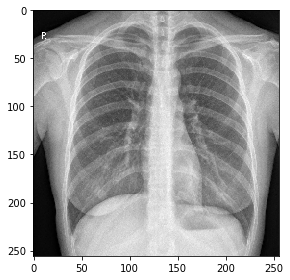

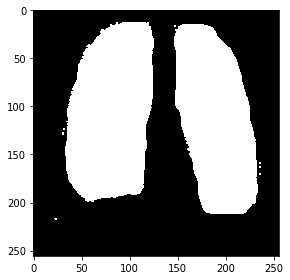

In [8]:
ix = random.randint(0, len(train_ids))
imshow(np.squeeze(X_train[ix]))
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()

In [0]:
def build_bn(width, height, n_classes, weights_path=None, train=False):
    inp = Input(shape=(height, width, 1))
    x = Lambda(lambda x: (x - 127.5)/255.0)(inp)

    # (1/2)
    y = Lambda(lambda x: tf.compat.v1.image.resize_bilinear(x, size=(int(x.shape[1])//2, int(x.shape[2])//2)), name='data_sub2')(x)
    y = Conv2D(32, 3, strides=2, padding='same', activation='relu', name='conv1_1_3x3_s2')(y)
    y = BatchNormalization(name='conv1_1_3x3_s2_bn')(y)
    y = Conv2D(32, 3, padding='same', activation='relu', name='conv1_2_3x3')(y)
    y = BatchNormalization(name='conv1_2_3x3_s2_bn')(y)
    y = Conv2D(64, 3, padding='same', activation='relu', name='conv1_3_3x3')(y)
    y = BatchNormalization(name='conv1_3_3x3_bn')(y)
    y_ = MaxPooling2D(pool_size=3, strides=2, name='pool1_3x3_s2')(y)
    
    y = Conv2D(128, 1, name='conv2_1_1x1_proj')(y_)
    y = BatchNormalization(name='conv2_1_1x1_proj_bn')(y)
    y_ = Conv2D(32, 1, activation='relu', name='conv2_1_1x1_reduce')(y_)
    y_ = BatchNormalization(name='conv2_1_1x1_reduce_bn')(y_)
    y_ = ZeroPadding2D(name='padding1')(y_)
    y_ = Conv2D(32, 3, activation='relu', name='conv2_1_3x3')(y_)
    y_ = BatchNormalization(name='conv2_1_3x3_bn')(y_)
    y_ = Conv2D(128, 1, name='conv2_1_1x1_increase')(y_)
    y_ = BatchNormalization(name='conv2_1_1x1_increase_bn')(y_)
    y = Add(name='conv2_1')([y,y_])
    y_ = Activation('relu', name='conv2_1/relu')(y)

    y = Conv2D(32, 1, activation='relu', name='conv2_2_1x1_reduce')(y_)
    y = BatchNormalization(name='conv2_2_1x1_reduce_bn')(y)
    y = ZeroPadding2D(name='padding2')(y)
    y = Conv2D(32, 3, activation='relu', name='conv2_2_3x3')(y)
    y = BatchNormalization(name='conv2_2_3x3_bn')(y)
    y = Conv2D(128, 1, name='conv2_2_1x1_increase')(y)
    y = BatchNormalization(name='conv2_2_1x1_increase_bn')(y)
    y = Add(name='conv2_2')([y,y_])
    y_ = Activation('relu', name='conv2_2/relu')(y)

    y = Conv2D(32, 1, activation='relu', name='conv2_3_1x1_reduce')(y_)
    y = BatchNormalization(name='conv2_3_1x1_reduce_bn')(y)
    y = ZeroPadding2D(name='padding3')(y)
    y = Conv2D(32, 3, activation='relu', name='conv2_3_3x3')(y)
    y = BatchNormalization(name='conv2_3_3x3_bn')(y)
    y = Conv2D(128, 1, name='conv2_3_1x1_increase')(y)
    y = BatchNormalization(name='conv2_3_1x1_increase_bn')(y)
    y = Add(name='conv2_3')([y,y_])
    y_ = Activation('relu', name='conv2_3/relu')(y)

    y = Conv2D(256, 1, strides=2, name='conv3_1_1x1_proj')(y_)
    y = BatchNormalization(name='conv3_1_1x1_proj_bn')(y)
    y_ = Conv2D(64, 1, strides=2, activation='relu', name='conv3_1_1x1_reduce')(y_)
    y_ = BatchNormalization(name='conv3_1_1x1_reduce_bn')(y_) 
    y_ = ZeroPadding2D(name='padding4')(y_)
    y_ = Conv2D(64, 3, activation='relu', name='conv3_1_3x3')(y_)
    y_ = BatchNormalization(name='conv3_1_3x3_bn')(y_)
    y_ = Conv2D(256, 1, name='conv3_1_1x1_increase')(y_)
    y_ = BatchNormalization(name='conv3_1_1x1_increase_bn')(y_)
    y = Add(name='conv3_1')([y,y_])
    z = Activation('relu', name='conv3_1/relu')(y)

    # (1/4)
    y_ = Lambda(lambda x: tf.compat.v1.image.resize_bilinear(x, size=(int(x.shape[1])//2, int(x.shape[2])//2)), name='conv3_1_sub4')(z)
    y = Conv2D(64, 1, activation='relu', name='conv3_2_1x1_reduce')(y_)
    y = BatchNormalization(name='conv3_2_1x1_reduce_bn')(y)
    y = ZeroPadding2D(name='padding5')(y)
    y = Conv2D(64, 3, activation='relu', name='conv3_2_3x3')(y)
    y = BatchNormalization(name='conv3_2_3x3_bn')(y)
    y = Conv2D(256, 1, name='conv3_2_1x1_increase')(y)
    y = BatchNormalization(name='conv3_2_1x1_increase_bn')(y)
    y = Add(name='conv3_2')([y,y_])
    y_ = Activation('relu', name='conv3_2/relu')(y)

    y = Conv2D(64, 1, activation='relu', name='conv3_3_1x1_reduce')(y_)
    y = BatchNormalization(name='conv3_3_1x1_reduce_bn')(y)
    y = ZeroPadding2D(name='padding6')(y)
    y = Conv2D(64, 3, activation='relu', name='conv3_3_3x3')(y)
    y = BatchNormalization(name='conv3_3_3x3_bn')(y)
    y = Conv2D(256, 1, name='conv3_3_1x1_increase')(y)
    y = BatchNormalization(name='conv3_3_1x1_increase_bn')(y)
    y = Add(name='conv3_3')([y,y_])
    y_ = Activation('relu', name='conv3_3/relu')(y)

    y = Conv2D(64, 1, activation='relu', name='conv3_4_1x1_reduce')(y_)
    y = BatchNormalization(name='conv3_4_1x1_reduce_bn')(y)
    y = ZeroPadding2D(name='padding7')(y)
    y = Conv2D(64, 3, activation='relu', name='conv3_4_3x3')(y)
    y = BatchNormalization(name='conv3_4_3x3_bn')(y)
    y = Conv2D(256, 1, name='conv3_4_1x1_increase')(y)
    y = BatchNormalization(name='conv3_4_1x1_increase_bn')(y)
    y = Add(name='conv3_4')([y,y_])
    y_ = Activation('relu', name='conv3_4/relu')(y)

    y = Conv2D(512, 1, name='conv4_1_1x1_proj')(y_)
    y = BatchNormalization(name='conv4_1_1x1_proj_bn')(y)
    y_ = Conv2D(128, 1, activation='relu', name='conv4_1_1x1_reduce')(y_)
    y_ = BatchNormalization(name='conv4_1_1x1_reduce_bn')(y_)
    y_ = ZeroPadding2D(padding=2, name='padding8')(y_)
    y_ = Conv2D(128, 3, dilation_rate=2, activation='relu', name='conv4_1_3x3')(y_)
    y_ = BatchNormalization(name='conv4_1_3x3_bn')(y_)
    y_ = Conv2D(512, 1, name='conv4_1_1x1_increase')(y_)
    y_ = BatchNormalization(name='conv4_1_1x1_increase_bn')(y_)
    y = Add(name='conv4_1')([y,y_])
    y_ = Activation('relu', name='conv4_1/relu')(y)

    y = Conv2D(128, 1, activation='relu', name='conv4_2_1x1_reduce')(y_)
    y = BatchNormalization(name='conv4_2_1x1_reduce_bn')(y)
    y = ZeroPadding2D(padding=2, name='padding9')(y)
    y = Conv2D(128, 3, dilation_rate=2, activation='relu', name='conv4_2_3x3')(y)
    y = BatchNormalization(name='conv4_2_3x3_bn')(y)
    y = Conv2D(512, 1, name='conv4_2_1x1_increase')(y)
    y = BatchNormalization(name='conv4_2_1x1_increase_bn')(y)
    y = Add(name='conv4_2')([y,y_])
    y_ = Activation('relu', name='conv4_2/relu')(y)

    y = Conv2D(128, 1, activation='relu', name='conv4_3_1x1_reduce')(y_)
    y = BatchNormalization(name='conv4_3_1x1_reduce_bn')(y)
    y = ZeroPadding2D(padding=2, name='padding10')(y)
    y = Conv2D(128, 3, dilation_rate=2, activation='relu', name='conv4_3_3x3')(y)
    y = BatchNormalization(name='conv4_3_3x3_bn')(y)
    y = Conv2D(512, 1, name='conv4_3_1x1_increase')(y)
    y = BatchNormalization(name='conv4_3_1x1_increase_bn')(y)
    y = Add(name='conv4_3')([y,y_])
    y_ = Activation('relu', name='conv4_3/relu')(y)

    y = Conv2D(128, 1, activation='relu', name='conv4_4_1x1_reduce')(y_)
    y = BatchNormalization(name='conv4_4_1x1_reduce_bn')(y)
    y = ZeroPadding2D(padding=2, name='padding11')(y)
    y = Conv2D(128, 3, dilation_rate=2, activation='relu', name='conv4_4_3x3')(y)
    y = BatchNormalization(name='conv4_4_3x3_bn')(y)
    y = Conv2D(512, 1, name='conv4_4_1x1_increase')(y)
    y = BatchNormalization(name='conv4_4_1x1_increase_bn')(y)
    y = Add(name='conv4_4')([y,y_])
    y_ = Activation('relu', name='conv4_4/relu')(y)

    y = Conv2D(128, 1, activation='relu', name='conv4_5_1x1_reduce')(y_)
    y = BatchNormalization(name='conv4_5_1x1_reduce_bn')(y)
    y = ZeroPadding2D(padding=2, name='padding12')(y)
    y = Conv2D(128, 3, dilation_rate=2, activation='relu', name='conv4_5_3x3')(y)
    y = BatchNormalization(name='conv4_5_3x3_bn')(y)
    y = Conv2D(512, 1, name='conv4_5_1x1_increase')(y)
    y = BatchNormalization(name='conv4_5_1x1_increase_bn')(y)
    y = Add(name='conv4_5')([y,y_])
    y_ = Activation('relu', name='conv4_5/relu')(y)

    y = Conv2D(128, 1, activation='relu', name='conv4_6_1x1_reduce')(y_)
    y = BatchNormalization(name='conv4_6_1x1_reduce_bn')(y)
    y = ZeroPadding2D(padding=2, name='padding13')(y)
    y = Conv2D(128, 3, dilation_rate=2, activation='relu', name='conv4_6_3x3')(y)
    y = BatchNormalization(name='conv4_6_3x3_bn')(y)
    y = Conv2D(512, 1, name='conv4_6_1x1_increase')(y)
    y = BatchNormalization(name='conv4_6_1x1_increase_bn')(y)
    y = Add(name='conv4_6')([y,y_])
    y = Activation('relu', name='conv4_6/relu')(y)

    y_ = Conv2D(1024, 1, name='conv5_1_1x1_proj')(y)
    y_ = BatchNormalization(name='conv5_1_1x1_proj_bn')(y_)
    y = Conv2D(256, 1, activation='relu', name='conv5_1_1x1_reduce')(y)
    y = BatchNormalization(name='conv5_1_1x1_reduce_bn')(y)
    y = ZeroPadding2D(padding=4, name='padding14')(y)
    y = Conv2D(256, 3, dilation_rate=4, activation='relu', name='conv5_1_3x3')(y)
    y = BatchNormalization(name='conv5_1_3x3_bn')(y)
    y = Conv2D(1024, 1, name='conv5_1_1x1_increase')(y)
    y = BatchNormalization(name='conv5_1_1x1_increase_bn')(y)
    y = Add(name='conv5_1')([y,y_])
    y_ = Activation('relu', name='conv5_1/relu')(y)

    y = Conv2D(256, 1, activation='relu', name='conv5_2_1x1_reduce')(y_)
    y = BatchNormalization(name='conv5_2_1x1_reduce_bn')(y)
    y = ZeroPadding2D(padding=4, name='padding15')(y)
    y = Conv2D(256, 3, dilation_rate=4, activation='relu', name='conv5_2_3x3')(y)
    y = BatchNormalization(name='conv5_2_3x3_bn')(y)
    y = Conv2D(1024, 1, name='conv5_2_1x1_increase')(y)
    y = BatchNormalization(name='conv5_2_1x1_increase_bn')(y)
    y = Add(name='conv5_2')([y,y_])
    y_ = Activation('relu', name='conv5_2/relu')(y)

    y = Conv2D(256, 1, activation='relu', name='conv5_3_1x1_reduce')(y_)
    y = BatchNormalization(name='conv5_3_1x1_reduce_bn')(y)
    y = ZeroPadding2D(padding=4, name='padding16')(y)
    y = Conv2D(256, 3, dilation_rate=4, activation='relu', name='conv5_3_3x3')(y)
    y = BatchNormalization(name='conv5_3_3x3_bn')(y)
    y = Conv2D(1024, 1, name='conv5_3_1x1_increase')(y)
    y = BatchNormalization(name='conv5_3_1x1_increase_bn')(y)
    y = Add(name='conv5_3')([y,y_])
    y = Activation('relu', name='conv5_3/relu')(y)

    h, w = y.shape[1:3].as_list()
    pool1 = AveragePooling2D(pool_size=(h,w), strides=(h,w), name='conv5_3_pool1')(y)
    pool1 = Lambda(lambda x: tf.compat.v1.image.resize_bilinear(x, size=(h,w)), name='conv5_3_pool1_interp')(pool1)
    pool2 = AveragePooling2D(pool_size=(h/2,w/2), strides=(h//2,w//2), name='conv5_3_pool2')(y)
    pool2 = Lambda(lambda x: tf.compat.v1.image.resize_bilinear(x, size=(h,w)), name='conv5_3_pool2_interp')(pool2)
    pool3 = AveragePooling2D(pool_size=(h/3,w/3), strides=(h//3,w//3), name='conv5_3_pool3')(y)
    pool3 = Lambda(lambda x: tf.compat.v1.image.resize_bilinear(x, size=(h,w)), name='conv5_3_pool3_interp')(pool3)
    pool6 = AveragePooling2D(pool_size=(h/4,w/4), strides=(h//4,w//4), name='conv5_3_pool6')(y)
    pool6 = Lambda(lambda x: tf.compat.v1.image.resize_bilinear(x, size=(h,w)), name='conv5_3_pool6_interp')(pool6)

    y = Add(name='conv5_3_sum')([y, pool1, pool2, pool3, pool6])
    y = Conv2D(256, 1, activation='relu', name='conv5_4_k1')(y)
    y = BatchNormalization(name='conv5_4_k1_bn')(y)
    aux_1 = Lambda(lambda x: tf.compat.v1.image.resize_bilinear(x, size=(int(x.shape[1])*2, int(x.shape[2])*2)), name='conv5_4_interp')(y)
    y = ZeroPadding2D(padding=2, name='padding17')(aux_1)
    y = Conv2D(128, 3, dilation_rate=2, name='conv_sub4')(y)
    y = BatchNormalization(name='conv_sub4_bn')(y)
    y_ = Conv2D(128, 1, name='conv3_1_sub2_proj')(z)
    y_ = BatchNormalization(name='conv3_1_sub2_proj_bn')(y_)
    y = Add(name='sub24_sum')([y,y_])
    y = Activation('relu', name='sub24_sum/relu')(y)

    aux_2 = Lambda(lambda x: tf.compat.v1.image.resize_bilinear(x, size=(int(x.shape[1])*2, int(x.shape[2])*2)), name='sub24_sum_interp')(y)
    y = ZeroPadding2D(padding=2, name='padding18')(aux_2)
    y_ = Conv2D(128, 3, dilation_rate=2, name='conv_sub2')(y)
    y_ = BatchNormalization(name='conv_sub2_bn')(y_)

    # (1)
    y = Conv2D(32, 3, strides=2, padding='same', activation='relu', name='conv1_sub1')(x)
    y = BatchNormalization(name='conv1_sub1_bn')(y)
    y = Conv2D(32, 3, strides=2, padding='same', activation='relu', name='conv2_sub1')(y)
    y = BatchNormalization(name='conv2_sub1_bn')(y)
    y = Conv2D(64, 3, strides=2, padding='same', activation='relu', name='conv3_sub1')(y)
    y = BatchNormalization(name='conv3_sub1_bn')(y)
    y = Conv2D(128, 1, name='conv3_sub1_proj')(y)
    y = BatchNormalization(name='conv3_sub1_proj_bn')(y)

    y = Add(name='sub12_sum')([y,y_])
    y = Activation('relu', name='sub12_sum/relu')(y)
    y = Lambda(lambda x: tf.compat.v1.image.resize_bilinear(x, size=(int(x.shape[1])*2, int(x.shape[2])*2)), name='sub12_sum_interp')(y)
    y = UpSampling2D(size=(4,4))(y)
    out = Conv2D(n_classes, 1, activation='sigmoid', name='conv6_cls')(y)

    if train:
        aux_1 = Conv2D(n_classes, 1, activation='sigmoid', name='sub4_out')(aux_1)
        aux_2 = Conv2D(n_classes, 1, activation='sigmoid', name='sub24_out')(aux_2)
        model = Model(inputs=inp, outputs=[out, aux_2, aux_1])
    else:
        model = Model(inputs=inp, outputs=out)
        
    if weights_path is not None:
        model.load_weights(weights_path, by_name=True)
    return model

In [10]:
model = build_bn(width = 256, height = 256, n_classes = 1, train=False)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 256, 256, 1)  0           input_1[0][0]                    
__________________________________________________________________________________________________
data_sub2 (Lambda)              (None, 128, 128, 1)  0           lambda[0][0]                     
__________________________________________________________________________________________________
conv1_1_3x3_s2 (Conv2D)         (None, 64, 64, 32)   320         data_sub2[0][0]                  
______________________________________________________________________________________________

In [0]:
earlystopper = EarlyStopping(patience=50, verbose=1)
checkpointer = ModelCheckpoint('model-ICNet-initial.h5', verbose=1, save_best_only=True)

In [12]:
results = model.fit(X_train, Y_train, validation_split=0.2, batch_size=16, epochs=400, 
                    callbacks=[earlystopper, checkpointer])

Train on 32 samples, validate on 9 samples
Epoch 1/400
16/32 [==============>...............] - ETA: 10s - loss: 0.8430 - accuracy: 0.4767
Epoch 00001: val_loss improved from inf to 0.70041, saving model to model-ICNet-initial.h5
32/32 [==============================] - 13s 407ms/sample - loss: 0.7294 - accuracy: 0.5988 - val_loss: 0.7004 - val_accuracy: 0.3708
Epoch 2/400
16/32 [==============>...............] - ETA: 0s - loss: 0.5402 - accuracy: 0.7330
Epoch 00002: val_loss improved from 0.70041 to 0.68360, saving model to model-ICNet-initial.h5
32/32 [==============================] - 3s 100ms/sample - loss: 0.4897 - accuracy: 0.7648 - val_loss: 0.6836 - val_accuracy: 0.5974
Epoch 3/400
16/32 [==============>...............] - ETA: 0s - loss: 0.4384 - accuracy: 0.8231
Epoch 00003: val_loss did not improve from 0.68360
32/32 [==============================] - 0s 6ms/sample - loss: 0.3786 - accuracy: 0.8432 - val_loss: 0.6958 - val_accuracy: 0.4749
Epoch 4/400
16/32 [==============>..

In [0]:
model.save_weights("model-ICNet-trained.h5", overwrite=True)
model.save("model-ICNet-trained-model.h5", overwrite=True)

In [14]:
model = load_model('model-ICNet-trained-model.h5')
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

# Create list of upsampled test masks
preds_test_upsampled = []
for i in range(len(preds_test)):
    preds_test_upsampled.append(resize(np.squeeze(preds_test[i]), 
                                       (sizes_test[i][0], sizes_test[i][1]), 
                                       mode='constant', preserve_range=True))

15/15 [==============================] - 0s 16ms/sample


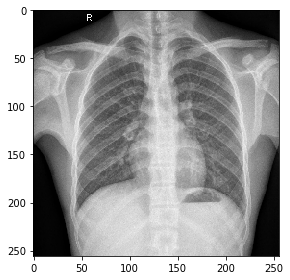

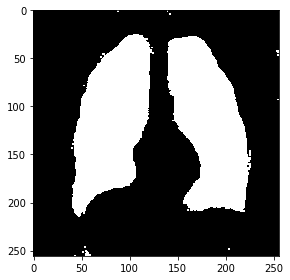

/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


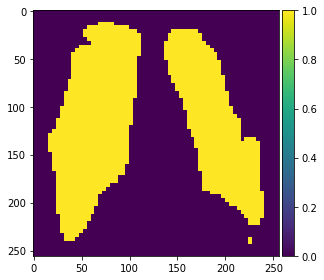

In [15]:
ix = random.randint(0, len(preds_train_t))
imshow(np.squeeze(X_train[ix]))
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]))
plt.show()

5
1


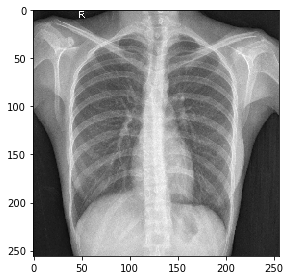

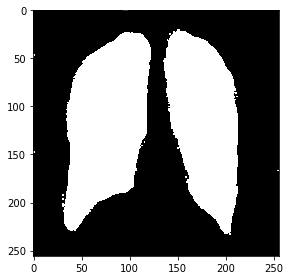

/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


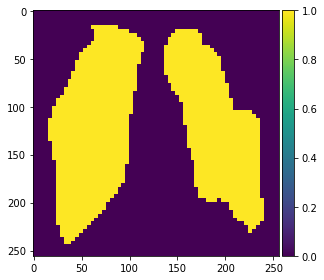

In [27]:
ix = random.randint(0, len(preds_val_t)-1)
print(len(preds_val_t))
print(ix)
imshow(np.squeeze(X_train[int(X_train.shape[0]*0.9):][ix]))
plt.show()
imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix]))
plt.show()
imshow(np.squeeze(preds_val_t[ix]))
plt.show()

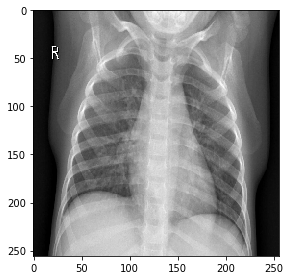

/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


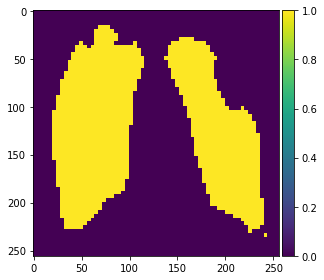

In [17]:
ix = random.randint(0, len(preds_val_t))
imshow(np.squeeze(X_test[ix]))
plt.show()
imshow(np.squeeze(preds_test_t[ix]))
plt.show()

In [0]:
preds_test_t[ix] = (preds_test_t[ix] + 127.5) * 255

In [19]:
preds_test_t[ix].shape

(256, 256, 1)

In [21]:
import cv2
backtorgb = cv2.cvtColor(preds_test_t[ix],cv2.COLOR_GRAY2RGB)
backtorgb[:,:,2]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

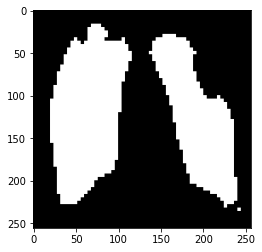

In [22]:
plt.imshow(backtorgb)

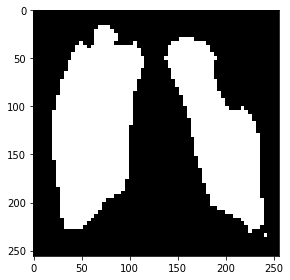

In [23]:
imshow(np.squeeze(preds_test_t[ix]))

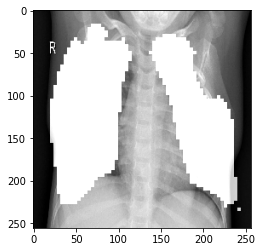

In [24]:

%matplotlib inline
img = cv2.addWeighted(X_test[ix], 1, preds_test_t[ix], 0.8, 0)
plt.imshow(img, cmap='gray')